In [1]:
import results
import seaborn as sns

<AxesSubplot:xlabel='NS', ylabel='ACC'>

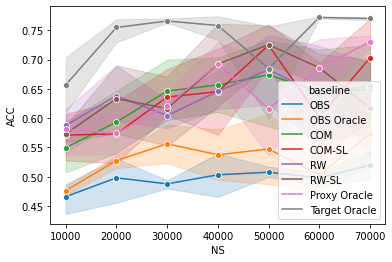

In [2]:
df, meandf  = results.get_erm_convergence_result_df('erm_convergence_rates_no_crossfit_beta3_alpha1')

df.reset_index(inplace=True)
sns.lineplot(data=df, x="NS", y="ACC", hue='baseline', ci=95, marker='o')

<AxesSubplot:xlabel='NS', ylabel='ACC'>

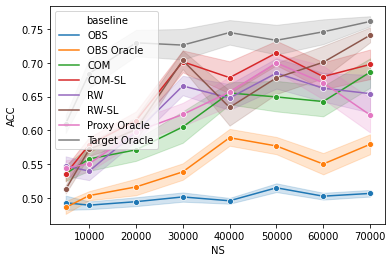

In [15]:
df, meandf  = results.get_erm_convergence_result_df('erm_convergence_rates_no_crossfit_beta3_alpha1_R15')

df.reset_index(inplace=True)
sns.lineplot(data=df, x="NS", y="ACC", hue='baseline', ci=68, marker='o')